# Исходный код

In [3]:
!pip install torchviz

#устанавливаем torchviz. Ошибок нет

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4132 sha256=dbb21cc716c0e151ab2fb731d2de5cfb4037ebaa9b260424ce3ee2f99a915261
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

#Устанавливаем требуемые библиотеки. Ошибок нет

In [9]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

#Создаем Callable объект transform, далее загружаем два датасета (train и test).
#При загрузке датасета из torchvision используем параметры: root='./data' - папка,
#куда будут загружены датасеты, параметр train=True или False, которые отвечают за
#то, будет ли это тренировочным датасетом или тестовым, параметр download=True,
#отвечающий за загрузку датасетов из интерента, если их нет в папке и параметр
#transform=transform, который преобразует изображения из датасета в тензор (хотя)
#можно было напрямую передать в параметр transforms.ToTensor. Уже по датасету
#понятно, что мы будем работать с изображениями. Ошибок нет

In [10]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#Создаются объекты DataLoader, с разделением на батчи по 64 штуки. Тут
#можно заметить первую серъезную проблему - shuffle=False. В датасете
#FashionMNIST классы расположены последовательно, поэтому передавать в будущую
#нейронную сеть батчи без перемешивания неправильно. Ошибка есть

In [5]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

#Здесь мы хотим удостовериться, что dataloader'ы созданы верно. Для этого
#мы создаем для них итераторы и берем первый элемент (то есть первый батч).
#Далее выводятся длины item'ов, они верные, длина равна 2, так как в элементе
#лежит батч и метки к нему. Если рассмотреть оба элемента "вблизи", то увидим
#что там лежит тензор размерами 64 (элементов в батче) на 1 (кол-во каналов) на
#28 (высота изображения) на 28 (длина изображения) и тензор меток. Ошибок нет

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [6]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [49, 32, 16, 10],
                 dropout_prob = 1.0
                 ):
        super().__init__()
        self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        self.layers = [nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)]
        self.norm = [nn.BatchNorm1d(inp_size, affine = False) for inp_size in layers_size[1:-1]]
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        batch = self.conv(batch).reshape(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

#В этом блоке мы создаем класс для реализации сверточной нейронной сети. В первую
#очередь мы реализуем конструктор класса, где сразу вызываем конструктор родительского
#класса. Далее применяется nn.Conv2d, который создаст первый слой нашей модели, но
#его настройки таковы, что вообще не меняют изображение, то есть фактически он не
#имеет смысла. Кроме того создается набор линейных слоев и к ним слои нормализации,
#а также объект ReLU и Dropout для повышения эффективности. Проблема здесь в списках,
#если мы в дальнейшем будем обучать модель, то параметры внутри слоев не будут меняться,
#а значит обучения по сути то и не будет. Нужно обернуть все в nn.ModuleList. Ошибка есть

#Далее реализуется метод forward. В нем мы работаем с отдельными батчами. Берем их
#размер (64) и применям к нему наш бессмысленный слой Conv2d, затем возвращяя тензор
#к нужной нам форме. Затем производится проход по сети. Ошибок нет

#С принтом все хорошо. Ошибок нет

In [7]:
mlp  = NNModel(dropout_prob = 0.1)

mlp.print_net()

#Все хорошо, но очевидно размеры входных слоев не подойдут. Надо, чтобы
#первый Linear был с 784 входами. Есть ошибка

Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
Linear(in_features=49, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


In [8]:
num_epochs = 1000
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01)

logger = {'train':[],
          'eval' :[]
          }
for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train()
    for batch in [train_item]:

        images, labels = batch
        images, labels = images.float(), labels.long()
        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    with torch.no_grad():

        eval_stat = []
        for batch in [train_item]:

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)
            loss.backward()
            optimizer.step()

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()

#Вполне понятно, что здесь реализуется обучение модели, но с ошибками.
#Во-первых, мы используем только первый элемент из наших DataLoader'ов,
#но полагаю, что здесь это было написано чисто для скорости. Во-вторых,
#у images отключены градиенты, что очевидно ошибка, без градиентов МОР
#никак не заработает. Также отсутсвует обнуление градиента на каждом шаге. Больше
#ошибок в тренировочной части нет. Но в валидационной части они есть: сразу видно,
#что мы снова проходимся по тренировочным данным, хотя нам требуются тестовые.
#Также в этой части нам не нужно делать optimizer.step() и loss.backword(). То есть 4
#ошибки

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x784 and 49x32)

In [ ]:
mlp

NNModel(
  (conv): Conv2d(1, 1, kernel_size=(4, 4), stride=(4, 4))
  (layers): ModuleList(
    (0): Linear(in_features=49, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=10, bias=True)
  )
  (norm): ModuleList(
    (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

# Исправленный код

In [58]:
!pip install torchviz

In [59]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from tqdm import tqdm
from torchviz import make_dot
import matplotlib.pyplot as plt

In [60]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download=True, transform=transform)

In [61]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [62]:
train_item = next(iter(train_loader))
test_item = next(iter(test_loader))
len(train_item), len(test_item), train_item[0].shape, train_item[1].shape

(2, 2, torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [63]:
class NNModel(nn.Module):
    def __init__(self,
                 layers_size = [49, 32, 16, 10],
                 dropout_prob = 1.0
                 ):
        super().__init__()
        # self.conv = nn.Conv2d(1, 1, kernel_size = 1, stride = 1)
        self.layers = nn.ModuleList([nn.Linear(layers_size[i], layers_size[i+1]) for i in range(len(layers_size)-1)])
        self.norm = nn.ModuleList([nn.BatchNorm1d(inp_size, affine = False) for inp_size in layers_size[1:-1]])
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, batch):
        bs = batch.shape[0]
        # batch = self.conv(batch).reshape(bs, 49)
        batch = batch.view(bs, -1)

        for i, layer in enumerate(self.layers):
            if i < len(self.layers) -1:
                batch = self.dropout(self.relu(self.norm[i](layer(batch))))
            else:
                batch = layer(batch)
        return batch

    def print_net(self):
        # print(self.conv)
        for i, layer in enumerate(self.layers):
            if i < len(self.layers) - 1:
                print(layer)
                print(self.norm[i])
                print(self.relu)
                print(self.dropout)
            else:
                print(layer)

        return

In [64]:
mlp  = NNModel(dropout_prob = 0.1, layers_size = [784, 32, 16, 10])

mlp.print_net()

Linear(in_features=784, out_features=32, bias=True)
BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=32, out_features=16, bias=True)
BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
ReLU()
Dropout(p=0.1, inplace=False)
Linear(in_features=16, out_features=10, bias=True)


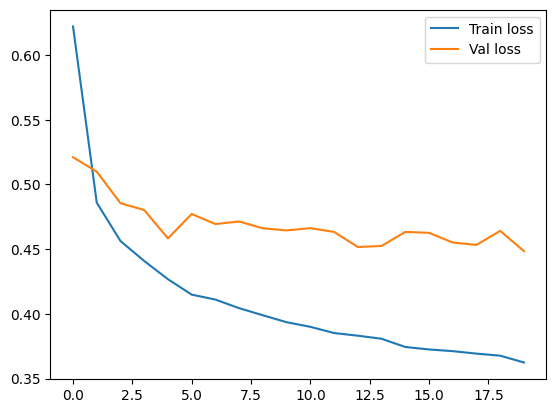

In [65]:
num_epochs = 20
DEBUG = False
ce_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr =  0.01)

logger = { 'train':[], 'eval' :[] }

for epoch in range(num_epochs):

    epoch_stat = []

    # train part

    mlp.train()
    for batch in train_loader:

        images, labels = batch
        images, labels = images.float(), labels.long()
        images.requires_grad = True

        optimizer.zero_grad()

        predictions = mlp(images)
        loss = ce_loss(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_stat.append(loss.item())

    if DEBUG: print(f"train loss value = {np.mean(epoch_stat)}")
    logger['train'].append(np.mean(epoch_stat))


    # eval part
    with torch.no_grad():

        eval_stat = []
        for batch in test_loader:

            images, labels = batch
            images, labels = images.float(), labels.long()

            predictions = mlp(images)
            loss = ce_loss(predictions, labels)

            eval_stat.append(loss.item())
    if DEBUG: print(f"eval loss value = {np.mean(eval_stat)}")
    logger['eval'].append(np.mean(eval_stat))

plt.plot(logger['train'], label='Train loss' )
plt.plot(logger['eval'], label='Val loss')
plt.legend()
plt.show()